# ICP: Iterative Closest Point

ICP is algorithm for aligning two sets of points, sometimes refered to as the point could (or point set) registration problem.

Given two sets of points, a target set

$$\mathcal{X}_t = \{x^t_i\}, x^t_i \in \mathbb{R}^N$$

and a source set

$$\mathcal{X}_s = \{x^s_i\}, x^s_i \in \mathbb{R}^N$$

find a transformation $T$, that when applied to the source set

$$\mathbf{T}\{x^s_i\} = \mathbf{R} x^s_i +\mathbf{p} \\
\mathbf{R} \in \mathrm{SO}(N) \\
\mathbf{p} \in \mathbb{R}^N $$

minimizes the distance between the two sets. This is done in an interative procdure.

1. Determine the nearest neighbor points between each set
2. Determine a transform $\mathbf{T}$ that minimizes $\sum_i || x^t_i -\mathbf{T}\{x^s_i\} ||$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


from data.load_corner import load_corner
from utils.transforms import SE2

(-0.6856097114827056,
 0.2945528434039384,
 -0.05928311056665436,
 1.2449453218997415)

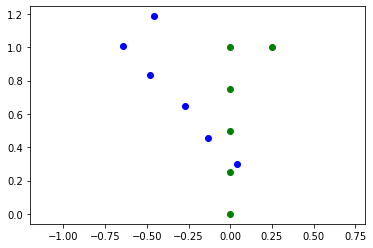

In [12]:
target_points = load_corner()

gt_transform = SE2()
gt_transform.t = np.random.rand(2,1) * 0.5
gt_transform.set_theta(np.random.rand()*100)

source_points = gt_transform @ load_corner(noise_sigma = 1e-2)

plt.scatter(target_points[0,:], target_points[1,:], c='g')
plt.scatter(source_points[0,:], source_points[1,:], c='b')
plt.axis('equal')

## Finding the optimal Transformation

Once we determine the nearest-neighbor associations, our task is to minimize the residuals between them. For point to point residuals, a closed-form optimal solution exists. 

### Optimal Rotation

Finding the optimal rotation can be done using the singular value decompostion algorithm.

First we compute the mean of the target and source points.
$$ \bar{x}^t = \frac{\sum_{i\in I}{x^t_i}}{I} $$
$$ \bar{x}^s = \frac{\sum_{i\in I}{x^s_i}}{I} $$

With those, we can recenter the points and compute the cross covariance matrix.
$$ \tilde{x}^t_i = x^t_i - \bar{x}^t$$
$$ \tilde{x}^s_i = x^s_i - \bar{x}^t$$
$$ C = \sum_{i\in I}{} \tilde{x}^t_i {\tilde{x}^s_i}^\top$$

if we take the SVD of $C$
$$ U D V^\top = \mathtt{SVD}(C)$$

the optimal rotation is
$$\mathbf{R} = U V^\top$$

### Optimal translation

Once we have the rotation, finding the optimal translation is as simple as computing the offsets of the two means, rotated by the rotation matrix, or
$$\mathbf{p} = \bar{x}^t - \mathbf{R} \bar{x}^s $$

In [13]:
# Initialize estimate to identity
current_transform = SE2()

**The following cell is meant to be run iteratively.**

1.944128986425528e-16


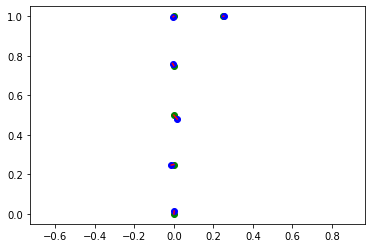

In [17]:
current_source_points = current_transform @ source_points

kd_tree = KDTree(target_points.T)
_, ii = kd_tree.query(current_source_points.T)

current_target_points = target_points[:, ii]
residuals = current_target_points - current_source_points

# Plotting details.
for i_s, i_t in enumerate(ii):
    plt.plot([current_source_points[0,i_s], target_points[0,i_t]],
             [current_source_points[1,i_s], target_points[1,i_t]], c='r')
    
plt.scatter(target_points[0,:], target_points[1,:], c='g')
plt.scatter(current_source_points[0,:], current_source_points[1,:], c='b')
plt.axis('equal')

# Find mean of source and target points
mean_source = np.mean(current_source_points, axis=1)[:,np.newaxis]
mean_target = np.mean(current_target_points, axis=1)[:,np.newaxis]

# Recenter points around their mean.
centered_source = (current_source_points - mean_source)
centered_target = (current_target_points - mean_target)

C = centered_target @ centered_source.T
u, s, vh = np.linalg.svd(C)
R = u @ vh
t = mean_target - R @ mean_source
update_transform  = SE2(R, t)
current_transform = update_transform @ current_transform

# Heuristic for stopping. If translation grows too small, it has converged.
print(np.linalg.norm(t))

In [18]:
diff_transform = gt_transform @ current_transform
print(f'Translation error: {np.linalg.norm(diff_transform.t)}')
print(f'Rotation error (deg): {diff_transform.get_theta()}')

Translation error: 0.0047403129803955165
Rotation error (deg): 0.38446993219803105
